## Question 2:

In Vernon Smith’s seminal 1962 paper, he performed a series of trading experiments. Each experiment, human participants are divided into buyers and sellers. Buyers and sellers are allocated a card with a reservation price (maximum price to buy; or minimum price to sell) and then asked to trade. When no more trades take place, a new “period” begins. At the start of the new period, buyers and sellers are re-allocated a new reservation card and asked to trade again. The experiment repeats for P periods. Results from one of Smith’s experiments (“Chart 5”) is copied below.

Using BSE, reproduce Smith’s Chart 5 experimental framework as closely as you can, but replace human participants with heterogeneous markets containing approximately equal numbers of ZIP, SHVR, and ZIC trading agents. Describe your experimental configuration. Then show two plots of demand and supply, before and after market shock, with equilibrium price indicated by horizontal dotted line. Finally, plot your trading results in the same style as Smith, with “transaction prices” on the y-axis and “transaction number (per period)” on the x-axis and dotted lines indicating theoretical equilibrium price and the start/end of each period. Describe how your results compare with Smith’s results. You can re-run your market as many times as you like, but you should only show results from one representative run.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
from BSE import market_session
import os

In [ ]:
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)
    z = np.empty(0)
    for i in range(n):
        cato = i+1
        trialId = trial_id + '_' + str(i)
        #tdump = open(trialId + '_avg_balance.csv','w')
        tdump = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': True}
        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, False)
        
        #tdump.close()
        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)
                z = np.append(z,cato)
    plt.figure()
    plt.plot(x, y, 'o', color='black')
    plt.xlabel('Time(s)')
    plt.ylabel('Transaction Price')
    print('Over!')
    return pd.DataFrame({'Time':x,'Price':y,'Period':z})

Over!


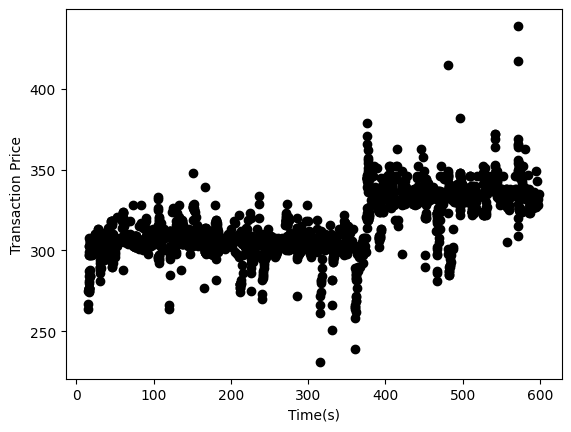

In [ ]:
trial_id = 'data/1127/Q2'
sellers_spec = [('ZIC', 10),('ZIP',10),('SHVR',10)]
buyers_spec = sellers_spec

traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

demand_range1 = (280,375)
demand_range2 = (300,470)
supply_range1 = (210, 360)  # equilibrium_price1 ~ 75
supply_range2 = (220, 380) # equilibrium_price2 ~ 175

start_time = 0
mid_time = 60 * 6
end_time = 60 * 10

supply_schedule = [{'from': start_time, 'to': mid_time, 'ranges': [supply_range1], 'stepmode': 'fixed'},
                   {'from': mid_time, 'to': end_time, 'ranges': [supply_range2], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': mid_time, 'ranges': [demand_range1], 'stepmode': 'fixed'},
                   {'from': mid_time, 'to': end_time, 'ranges': [demand_range2], 'stepmode': 'fixed'}]
# create a market maker with default parameter settings and add to traders_spec
# mrktmakers_spec = [('MMM01', 1)]
# traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec, 'mrktmakers': mrktmakers_spec}
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}
order_interval = 15 # the time interval that order schedule takes to cycle through buyers and sellers and supply them with new orders
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}
n=3

df2 = n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched)

In [ ]:
demand_range1 = (280,375)
demand_range2 = (300,470)
supply_range1 = (210, 360)  # equilibrium_price1 ~ 75
supply_range2 = (220, 380) 

In [ ]:
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

def make_supply_demand_plot(bids, asks,equalibrium):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    colors = ['r','b']
    pr = 0

    demand_label = ['D_1',"D_2"]
    supply_label = ['S_1',"S_2'"]
    for bid in bids:
        i=0
        for b in bid:            
            if pr != 0 and b!=bid[-1]:
                # vertical line
                ax.plot([volB,volB], [pr,b], 'r-')
            elif pr!=0 and b==bid[-1]:
                ax.plot([volB,volB], [pr,b], 'r-',label = demand_label[i])
        # horizontal lines
            line, = ax.plot([volB,volB+1], [b,b], 'r-')
            volB += 1
            pr = b
        pr=0
        volS = 0
        volB = 0
        i+=1

        
    pr = 0
    for ask in asks:
        i=0
        for s in ask:
            if pr != 0 and s!=ask[-1]:
                # vertical line
                ax.plot([volS,volS], [pr,s], 'b-')
            elif pr!=0 and s==ask[-1]:
                ax.plot([volS,volS], [pr,s], 'b-',label = supply_label[i])
            # horizontal lines
            line, = ax.plot([volS,volS+1], [s,s], 'b-')
            volS += 1
            pr = s
            
        pr=0
        volS = 0
        volB = 0
        i+=1
    a = max(ax.get_xlim())
    if bids or asks:
        plt.legend()
    for p in equalibrium:
        ax.plot([0,a],[p,p],linestyle = '--',color='gray',linewidth = 1)
    plt.show()


def plot_sup_dem(seller_num, buyer_num, stepmode,equilibrium, dem_ranges=[], sup_ranges = []):
    asks = [] # ask = [[],[]]
    if len(dem_ranges)>1:
        for sup_range in sup_ranges:
            ask_list = []
            for s in range(seller_num):
                ask_list.append(getorderprice(s, sup_range, seller_num, stepmode))
            ask_list.sort()
            asks.append(ask_list)
        
        bids = []
        for dem_range in dem_ranges:
            bid_list = []
            for b in range(buyer_num):
                bid_list.append(getorderprice(b, dem_range, buyer_num, stepmode))
            bid_list.sort()
            bid_list.reverse()
            bids.append(bid_list)
        
    make_supply_demand_plot(bids, asks,equilibrium) 

In [ ]:
def equilibrium_price(supply_range,demand_range):
    sup_spread = max(supply_range) - min(supply_range)
    dem_spread = max(demand_range) - min(demand_range)
    return (sup_spread * max(demand_range) + dem_spread * min(supply_range))/(sup_spread+dem_spread)
equilibrium_price1 = equilibrium_price(supply_range1,demand_range1)
equilibrium_price2 = equilibrium_price(supply_range2,demand_range2)
eq_p = [equilibrium_price1,equilibrium_price2]

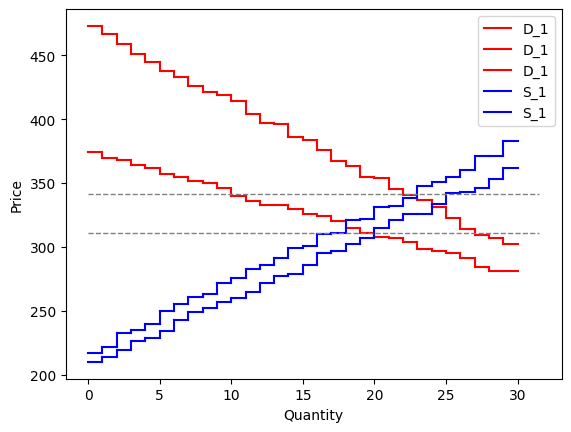

In [ ]:
plot_sup_dem(30,30,'jittered',eq_p,[[demand_range1],[demand_range2]],[[supply_range1],[supply_range2]])

Over!
Over!


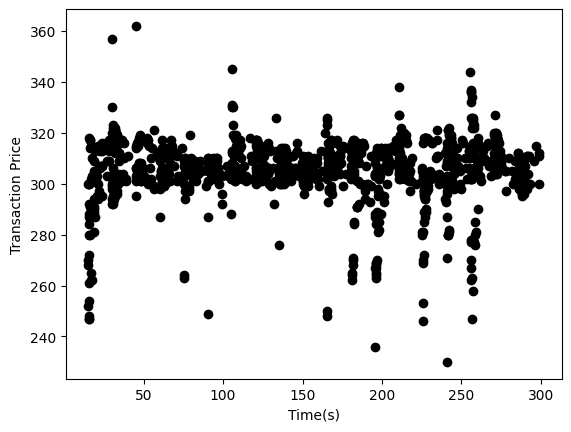

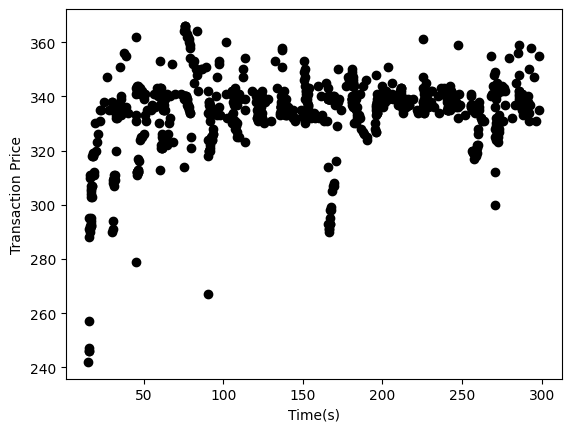

In [ ]:
trial_id = 'data/Q2/before'
n = 4
start_time = 0
end_time = 60 * 5
supply_schedule1 = [{'from': start_time, 'to':end_time, 'ranges': [supply_range1], 'stepmode': 'jittered'}]
demand_schedule1 = [{'from': start_time, 'to': end_time, 'ranges': [demand_range1], 'stepmode': 'jittered'}]
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}
order_interval = 15 
order_sched = {'sup': supply_schedule1, 'dem': demand_schedule1,
               'interval': order_interval, 'timemode': 'periodic'}
df3 = n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched)

n=2
trial_id = 'data/Q2/after'
supply_schedule2 = [{'from': start_time, 'to':end_time, 'ranges': [supply_range2], 'stepmode': 'jittered'}]
demand_schedule2 = [{'from': start_time, 'to': end_time, 'ranges': [demand_range2], 'stepmode': 'jittered'}]
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}
order_sched = {'sup': supply_schedule2, 'dem': demand_schedule2,
               'interval': order_interval, 'timemode': 'periodic'}
df4 = n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched)

Loaded: before_0_tape.csv
Loaded: before_1_tape.csv
Loaded: before_2_tape.csv
Loaded: before_3_tape.csv
Loaded: after_0_tape.csv
Loaded: after_1_tape.csv


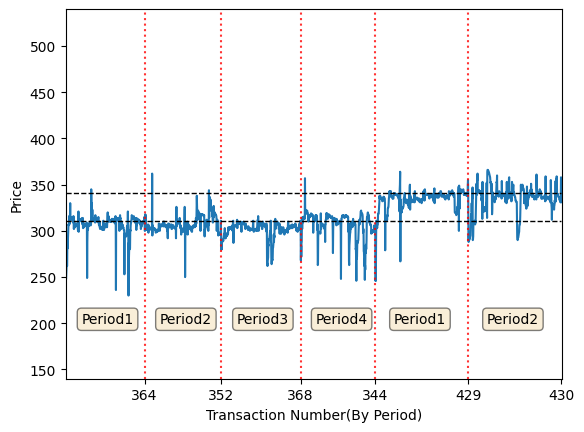

In [ ]:
path = "data/Q2"
D1 = []
for filename in os.listdir(path):
    if filename.endswith(".csv") and 'before' in str(filename) and 'tape' in str(filename):
        df = pd.read_csv(os.path.join(path, filename))
        if df.shape[0] != 0:
            print("Loaded:", filename) 
        a = df.iloc[:,-1]
        D1.append(a)
for filename in os.listdir(path):
    if filename.endswith(".csv") and 'after' in str(filename) and 'tape' in str(filename):
        df = pd.read_csv(os.path.join(path, filename))
        if df.shape[0] != 0:
            print("Loaded:", filename) 
        a = df.iloc[:,-1]
        D1.append(a)

dic = {'Period1':D1[0],'Period2':D1[1],'Period3':D1[2],'Period4':D1[3],'Period5':D1[4],
       'Period6':D1[5]}
len1, len2, len3, len4, len5, len6 = len(D1[0]), len(D1[1]), len(D1[2]),len(D1[3]),len(D1[4]),len(D1[5])
dic = pd.DataFrame(dic)
D1 = [*D1[0],*D1[1],*D1[2],*D1[3],*D1[4],*D1[5]]
len2 = len1+len2
len3 = len2+len3
len4 = len3+len4
len5 = len4+len5
len6 = len5+len6
bbox_set = {'boxstyle':'round','facecolor':'wheat','alpha':0.5}
pos = 200
fig, ax = plt.subplots()
ax.set_ylim(140,540)
ax.set_xlim(0,len(D1)+1)
ax.plot(range(1,len(D1)+1), D1, linestyle='-')
ax.plot([len1,len1], [140, 540], ':', color='red', alpha=0.8)
ax.plot([len2,len2], [140, 540], ':', color='red', alpha=0.8)
ax.plot([len3,len3], [140, 540], ':', color='red', alpha=0.8)
ax.plot([len4,len4], [140, 540], ':', color='red', alpha=0.8)
ax.plot([len5,len5], [140, 540], ':', color='red', alpha=0.8)
ax.plot([0,len(D1)],[equilibrium_price1,equilibrium_price1],linestyle = '--',color='black',linewidth =1)
ax.plot([0,len(D1)],[equilibrium_price2,equilibrium_price2],linestyle = '--',color='black',linewidth =1)
ax.text(1/5*len1,pos,'Period1',bbox=bbox_set)
ax.text(len1+1/5*(len2-len1),pos,'Period2',bbox=bbox_set)
ax.text(len2+1/5*(len3-len2),pos,'Period3',bbox=bbox_set)
ax.text(len3+1/5*(len4-len3),pos,'Period4',bbox=bbox_set)
ax.text(len4+1/5*(len5-len4),pos,'Period1',bbox=bbox_set)
ax.text(len5+1/5*(len6-len5),pos,'Period2',bbox=bbox_set)
ax.set_xticks([len1, len2, len3, len4, len5,len6])
ax.set_xticklabels([len1,len2-len1,len3-len2,len4-len3,len5-len4,len6-len5])
ax.set_xlabel('Transaction Number(By Period)')
ax.set_ylabel('Price')
plt.show()